In [1]:
import keras.utils
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Import data

In [2]:
variable = {'phF': 0, 'MF': 1}['phF'] # TODO: for now just classify one variable

In [3]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature']

In [4]:
path = './Output'

In [5]:
# dimensions
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(path) if p[:14] == 'feature_vector']), \
                             *np.load(path + '/feature_vector0.npy').shape

# metadata (subjectID etc.)
with open(path + '/metadata.txt') as f:
    metadata = f.read()
metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

# Train/validation split

In [6]:
VALIDATION_SIZE = 0.2

In [7]:
# use unaugmented data for validation set
non_augmented = [i for i, meta in enumerate(metadata) if meta['augmented'] == False]

validation_indices = np.random.choice(non_augmented, int(N * VALIDATION_SIZE), replace=False)
training_indices = np.delete(np.arange(N), validation_indices)

In [8]:
print(f'Training set: {len(training_indices)}')
print(f'Validation set: {len(validation_indices)}')

Training set: 2478
Validation set: 619


# Define data generator

In [9]:
# image-wise
def rgb2gray(rgb):
    """greyscale = 0.2989 * red + 0.5870 * green + 0.1140 * blue"""
    return np.dot(rgb[:, :, :3], [0.2989, 0.5870, 0.1140])

In [10]:
# test
temp = np.load(path + f'/feature_vector{0}.npy', allow_pickle=True)
temp.shape

(370, 100, 30)

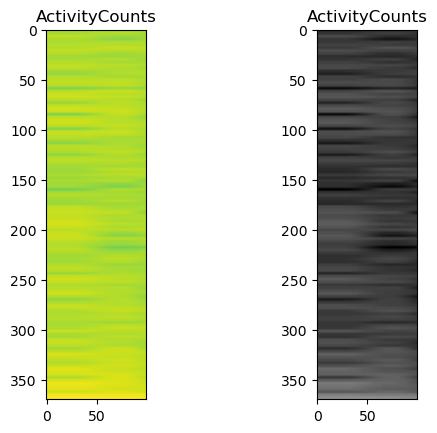

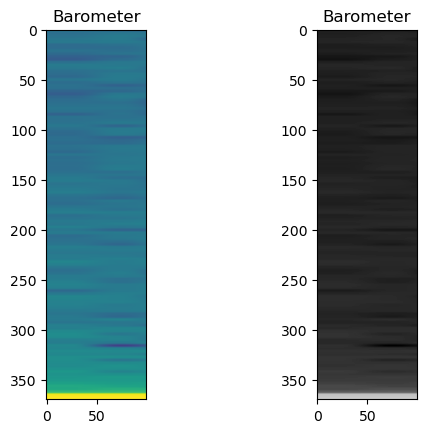

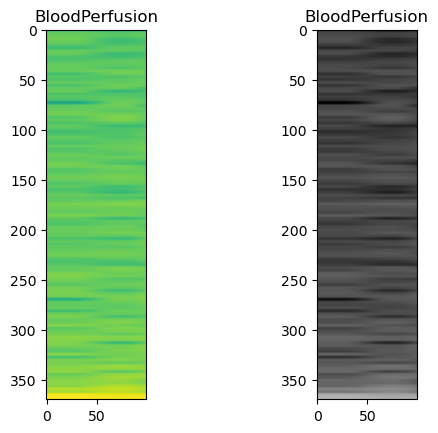

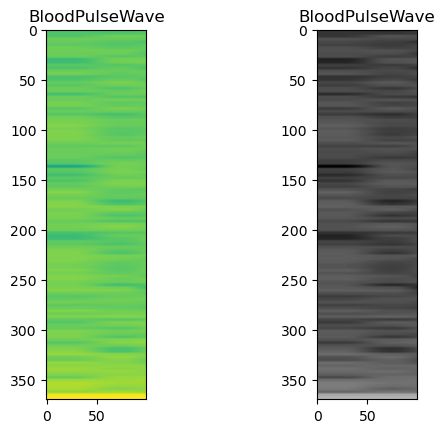

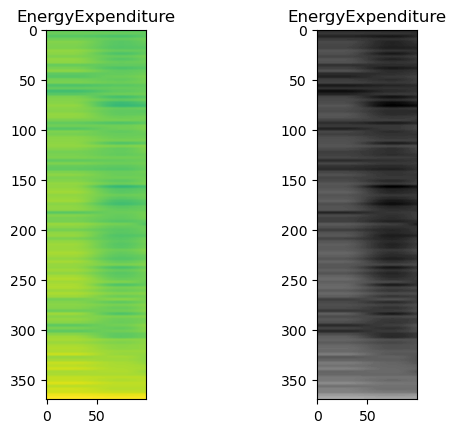

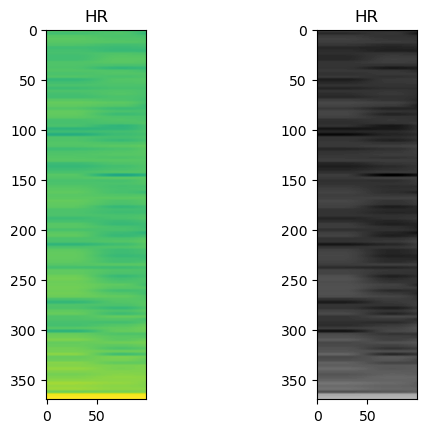

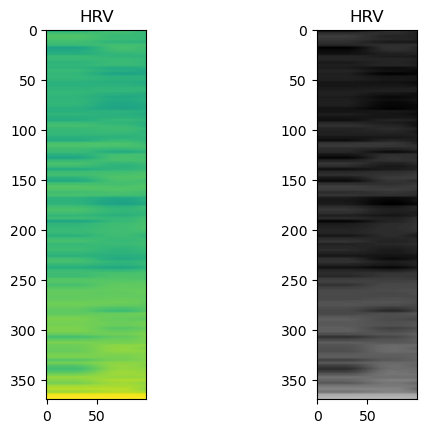

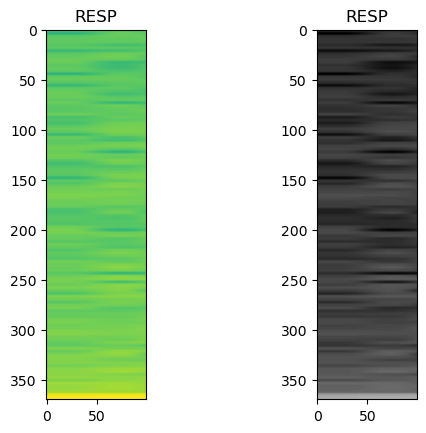

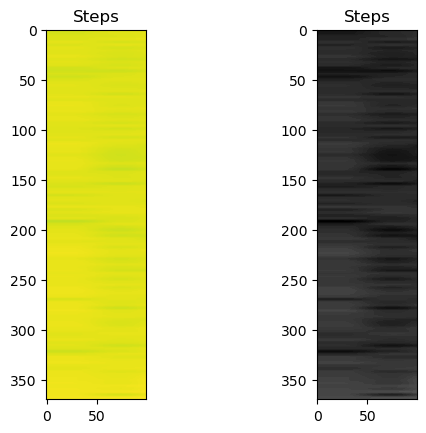

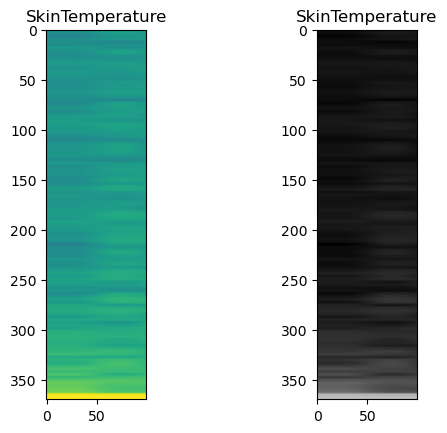

(370, 100, 10)

In [14]:
# test
images_gray = np.empty((HEIGHT, WIDTH, len(VARIABLES)))
for i in range(len(VARIABLES)):
    image_rgb = temp[:, :, (3 * i): (3 * (i + 1))]
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(VARIABLES[i])

    plt.subplot(1, 2, 2)
    image_gray = rgb2gray(image_rgb)
    plt.imshow(image_gray, cmap='gray')

    plt.title(VARIABLES[i])
    plt.show()

    images_gray[:, :, i] = image_gray

images_gray.shape

In [24]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=len(VARIABLES), shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # TODO: int for non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            images_rgb = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            images_gray = np.empty((HEIGHT, WIDTH, self.n_channels))
            for j in range(len(VARIABLES)):
                image_rgb = images_rgb[:, :, (3 * j): (3 * (j + 1))]
                image_gray = rgb2gray(image_rgb)
                images_gray[:, :, j] = image_gray
            X[i, ] = images_gray
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[variable] # TODO: for now just one variable

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# Upsampling

In [25]:
UPSAMPLING_STRATEGY = 'nothing' # ['repeat', 'nothing']

In [26]:
def check_imbalance(path_to_labels, indices):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0] # TODO: for now just one variable
    negatives = np.where(y[:, variable] == 0)[0] # TODO: for now just one variable

    return np.array(indices)[positives], np.array(indices)[negatives]


# validation set
positives, negatives = check_imbalance(path, validation_indices)
print(f'validation: (+: {len(positives)}, -: {len(negatives)})')

# training set
positives, negatives = check_imbalance(path, training_indices)
print(f'train_set: (+: {len(positives)}, -: {len(negatives)})')

sample_weight = len(negatives) / len(positives) # for weighted cross-entropy

# upsampling training set
if UPSAMPLING_STRATEGY == 'repeat':
    upsampled_indices = np.random.choice(negatives, size=(len(positives) - len(negatives)), replace=True) # with replacement
    upsampled_indices = np.append(upsampled_indices, np.arange(N))
    training_indices = np.append(positives, negatives) # update

    positives, negatives = check_imbalance(path, upsampled_indices)
    print(f'train_set (upsampled): (+: {len(positives)}, -: {len(negatives)})')
if UPSAMPLING_STRATEGY == 'nothing':
    pass

print(f'\nWeighted loss function: weight = {sample_weight}')

validation: (+: 447, -: 172)
train_set: (+: 1845, -: 633)

Weighted loss function: weight = 0.34308943089430893


# CNN

Data generators

In [27]:
training_batch_generator = DataGenerator(data_path=path, indices_dataset=training_indices, batch_size=128)
validation_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=32) # TODO: use test set to avoid mixing

Model

In [42]:
# wrapper functions
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits


class accuracy_with_logits(tf.keras.metrics.Accuracy):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(accuracy_with_logits, self).update_state(y_true, y_pred, sample_weight)

class recall_with_logits(tf.keras.metrics.Recall):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(recall_with_logits, self).update_state(y_true, y_pred, sample_weight)

class precision_with_logits(tf.keras.metrics.Precision):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(precision_with_logits, self).update_state(y_true, y_pred, sample_weight)

class BalancedAccuracy(tf.keras.metrics.Metric):

    def __init__(self, name='balanced_accuracy', **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)
        self.recall = self.add_weight(name="ctp", initializer="zeros")
        self.specificity = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))

        tp = K.sum(y_true * y_pred)
        tn = K.sum((1 - y_true) * (1 - y_pred))
        fp = K.sum((1 - y_true) * y_pred)
        fn = K.sum(y_true * (1 - y_pred))

        self.recall.assign(tp / (tp + fn + K.epsilon()))
        self.specificity.assign(tn / (tn + fp + K.epsilon()))

    def result(self):
        return 0.5 * (self.recall + self.specificity)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.recall.assign(0.0)
        self.specificity.assign(0.0)

class MCC(tf.keras.metrics.Metric):

    def __init__(self, name='mcc', **kwargs):
        super(MCC, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="ctp", initializer="zeros")
        self.tn = self.add_weight(name="ctp", initializer="zeros")
        self.fp = self.add_weight(name="ctp", initializer="zeros")
        self.fn = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))

        self.tp = K.sum(y_true * y_pred)
        self.tn = K.sum((1 - y_true) * (1 - y_pred))
        self.fp = K.sum((1 - y_true) * y_pred)
        self.fn = K.sum(y_true * (1 - y_pred))

    def result(self):
        return abs((self.tp * self.tn - self.fp * self.fn) /
                   ((self.tp + self.fp) * (self.tp + self.fn) * (self.tn + self.fp) * (self.tn + self.fn) + K.epsilon())**0.5)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.tp = 0.0
        self.tn = 0.0
        self.fp = 0.0
        self.fn = 0.0

class F1(tf.keras.metrics.Metric):

    def __init__(self, name='f1', **kwargs):
        super(F1, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="ctp", initializer="zeros")
        self.tn = self.add_weight(name="ctp", initializer="zeros")
        self.fp = self.add_weight(name="ctp", initializer="zeros")
        self.fn = self.add_weight(name="ctp", initializer="zeros")

        self.positives = self.add_weight(name="ctp", initializer="zeros")
        self.positives_pred = self.add_weight(name="ctp", initializer="zeros")
        self.negatives = self.add_weight(name="ctp", initializer="zeros")
        self.negatives_pred = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))

        self.positives = K.sum(y_true)
        self.positives_pred = K.sum(y_pred)
        self.negatives = K.sum((1 - y_true))
        self.negatives_pred = K.sum((1 - y_pred))

        self.tp = K.sum(y_true * y_pred)
        self.tn = K.sum((1 - y_true) * (1 - y_pred))
        self.fp = K.sum((1 - y_true) * y_pred)
        self.fn = K.sum(y_true * (1 - y_pred))

    def result(self):
        precision = self.tp / (self.positives_pred + K.epsilon())
        recall = self.tp / (self.positives + K.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

        precision_negatives = self.tn / (self.negatives_pred + K.epsilon())
        recall_negatives = self.tn / (self.negatives + K.epsilon())
        f1_negatives = 2 * (precision_negatives * recall_negatives) / (precision_negatives + recall_negatives + K.epsilon())

        return (self.positives * f1 + self.negatives * f1_negatives) / (self.positives + self.negatives + K.epsilon())

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.positives = 0.0
        self.positives_pred = 0.0
        self.negatives = 0.0
        self.negatives_pred = 0.0

        self.tp = 0.0
        self.tn = 0.0
        self.fp = 0.0
        self.fn = 0.0

In [43]:
model = models.Sequential(name='custom_CNN')

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(370, 100, len(VARIABLES)), padding='same', name='conv1-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1-2'))
model.add(BatchNormalization(name='batch_norm1')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool1'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-2'))
model.add(BatchNormalization(name='batch_norm2')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool2'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-2'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-3'))
model.add(BatchNormalization(name='batch_norm3')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool3'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-3'))
model.add(BatchNormalization(name='batch_norm4')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool4'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-3'))
model.add(BatchNormalization(name='batch_norm5')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool5'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-3'))
model.add(BatchNormalization(name='batch_norm6')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool6'))

model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense1'))
model.add(Dropout(0.4, name='dropout1')) # TODO: worth it? parameter scale adequate?
model.add(Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense2'))
model.add(Dropout(0.3, name='dropout2')) # TODO: worth it? parameter scale adequate?
model.add(Dense(1, kernel_regularizer='l2', name='dense3'))

model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy(sample_weight), metrics=[accuracy_with_logits(),
                                                                                                       recall_with_logits(),
                                                                                                       precision_with_logits(),
                                                                                                       BalancedAccuracy(),
                                                                                                       MCC(),
                                                                                                       F1()])

model.summary()

Model: "custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1-1 (Conv2D)             (None, 370, 100, 16)      1456      
_________________________________________________________________
conv1-2 (Conv2D)             (None, 370, 100, 16)      2320      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 370, 100, 16)      64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 185, 50, 16)       0         
_________________________________________________________________
conv2-1 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
conv2-2 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 185, 50, 16)       6

Training

In [44]:
%%time
# save best performing model
checkpoint_path_mcc = './temp/checkpoint_model_mcc'
model_checkpoint_callback_mcc = ModelCheckpoint(filepath=checkpoint_path_mcc,
                                            save_weights_only=True,
                                            monitor='val_mcc',
                                            save_best_only=True)
checkpoint_path_f1 = './temp/checkpoint_model_f1'
model_checkpoint_callback_f1 = ModelCheckpoint(filepath=checkpoint_path_f1,
                                            save_weights_only=True,
                                            monitor='val_f1',
                                            save_best_only=True)

# train
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=200,
                              callbacks=[model_checkpoint_callback_mcc, model_checkpoint_callback_f1])

Epoch 1/200
19/19 [==============================] - 75s 4s/step - loss: 1.1055 - accuracy: 0.4675 - recall_with_logits_6: 0.4335 - precision_with_logits_6: 0.7448 - balanced_accuracy: 0.5077 - mcc: 0.0138 - f1: 0.4695 - val_loss: 1.1005 - val_accuracy: 0.7171 - val_recall_with_logits_6: 1.0000 - val_precision_with_logits_6: 0.7171 - val_balanced_accuracy: 0.5000 - val_mcc: 0.0000e+00 - val_f1: 0.4808
Epoch 2/200
19/19 [==============================] - 68s 4s/step - loss: 1.1060 - accuracy: 0.4531 - recall_with_logits_6: 0.4245 - precision_with_logits_6: 0.7266 - balanced_accuracy: 0.5528 - mcc: 0.0886 - f1: 0.5532 - val_loss: 1.0958 - val_accuracy: 0.7220 - val_recall_with_logits_6: 1.0000 - val_precision_with_logits_6: 0.7220 - val_balanced_accuracy: 0.5000 - val_mcc: 0.0000e+00 - val_f1: 0.5602
Epoch 3/200
19/19 [==============================] - 71s 4s/step - loss: 1.0974 - accuracy: 0.4692 - recall_with_logits_6: 0.4397 - precision_with_logits_6: 0.7409 - balanced_accuracy: 0.535

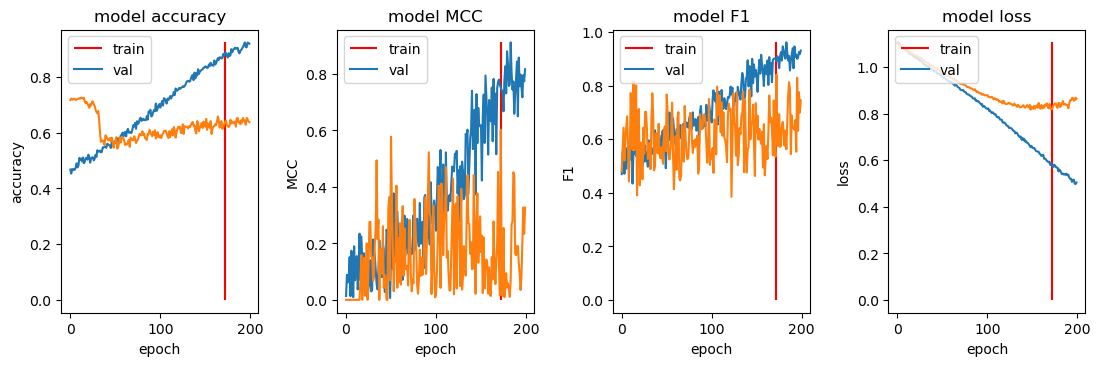

In [96]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.7,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# metric
plt.subplot(1, 4, 1)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['accuracy'] + history.history['val_accuracy']), color='red')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 4, 2)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['mcc'] + history.history['val_mcc']), color='red')
plt.plot(history.history['mcc'])
plt.plot(history.history['val_mcc'])
plt.title('model MCC')
plt.ylabel('MCC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 4, 3)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['f1'] + history.history['val_f1']), color='red')
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# loss
plt.subplot(1, 4, 4)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['loss'] + history.history['val_loss']), color='red')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

# Evaluation

In [46]:
# save latest model
current_model = tf.keras.models.clone_model(model)

In [47]:
# load best performing model
model.load_weights(checkpoint_path_f1)

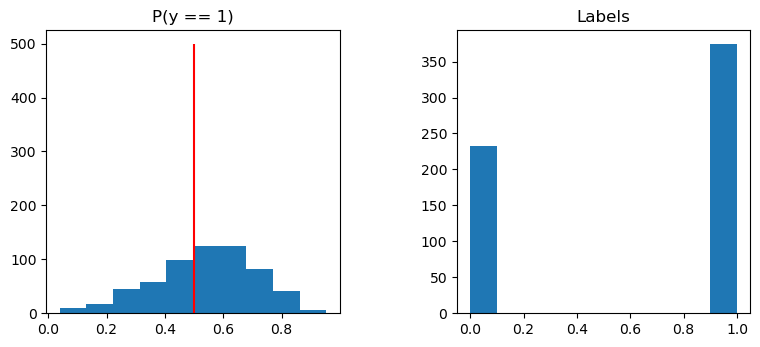

In [48]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [49]:
# load test data
print(f'Test set: {len(validation_indices)}') # TODO: separate test-set

test_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=1) # TODO: separate test-set
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set: 619


accuracy: 0.617124394184168
balanced accuracy: 0.581096196868009
f1 (weighted): 0.6325382932152749
recall (weighted): 0.617124394184168
precision (weighted): 0.6603877128534759


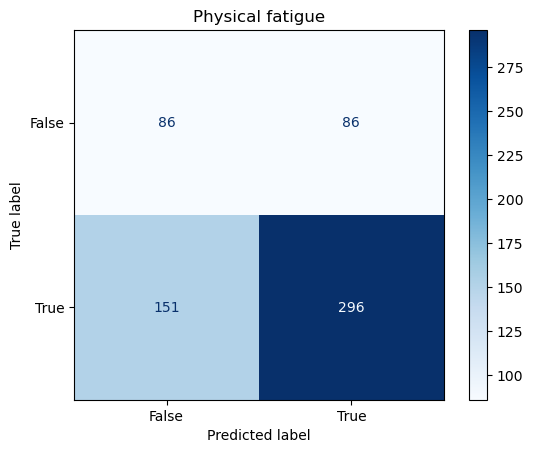

In [50]:
# classification metrics
# predict
y_test_pred = model.predict(test_batch_generator)
y_test_pred = tf.math.sigmoid(y_test_pred).numpy() # TODO: for logits
y_test_pred = np.round(y_test_pred)

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

# Save data

In [51]:
# save history
with open('./temp/history_acc','w') as dat:
    dat.write(str(history.history['accuracy']))

with open('./temp/history_val_acc','w') as dat:
    dat.write(str(history.history['val_accuracy']))

with open('./temp/history_loss','w') as dat:
    dat.write(str(history.history['loss']))

with open('./temp/history_val_loss','w') as dat:
    dat.write(str(history.history['val_loss']))

with open('./temp/history_mcc','w') as dat:
    dat.write(str(history.history['mcc']))

with open('./temp/history_val_mcc','w') as dat:
    dat.write(str(history.history['val_mcc']))

with open('./temp/history_f1','w') as dat:
    dat.write(str(history.history['f1']))

with open('./temp/history_val_f1','w') as dat:
    dat.write(str(history.history['val_f1']))

In [52]:
# save latest model
model.save('./temp/checkpoint_latest')

INFO:tensorflow:Assets written to: ./temp/checkpoint_latest\assets


INFO:tensorflow:Assets written to: ./temp/checkpoint_latest\assets
